# Impact of MS filter disable on ACA planning constraint

This notebook contains a simple analysis to estimate the impact of disabling the OBC multiple stars suspected filter (MS filter) on the ACA planning constraint.  This is done by the following process:

- Determine the limiting magnitude of the ACA around 2016:001 assuming acquisition statistics with the MS filter ENABLED.  The limiting magnitude is defined as the ACA magnitude corresponding to a 50% acquisition probability, and is a function of both temperature and time (because of ongoing radiation damage).
- Estimate the expected temperature increase profile for the ACA.  Over the time range from around 2012:180 to 2014:180 the ACA CCD temperature was not significantly constrained by an explicit ACA constraint.  The derived temperature increase of about 1.5 degC/year is expected to be sustainable over the next 6 years.
- Compute the ACA limiting magnitude at yearly intervals for the next 6 years, assuming the MS filter is DISABLED and an increase of 1.5 degC/year from the median value for a +/- 60 day span centered at 2016:001.
- Interpolate this curve to determine the date at which the curve matches the limiting magnitude with MS filter disabled.
- This date is around 2019:292.


**Conclusion: the ACA planning constraint for late-2019 will be similar to the constraint at 2016:001.**

In [1]:
import sys
sys.path.insert(0, '/home/aldcroft/git/chandra_aca')

In [2]:
from chandra_aca.star_probs import set_fit_pars, mag_for_p_acq
from Ska.engarchive import fetch_sci as fetch
from Chandra.Time import DateTime
from Ska.Matplotlib import plot_cxctime
import matplotlib.pyplot as plt
import Ska.Numpy
%matplotlib inline

In [3]:
NOW = DateTime('2016:001')

In [4]:
set_fit_pars(ms_enabled=True)

In [5]:
dat = fetch.Msid('aacccdpt', NOW - 60, NOW + 60, stat='5min')

In [6]:
t_dat_now = np.median(dat.vals)
t_dat_now

-14.684631

In [7]:
mag50_enabled = mag_for_p_acq(0.5, date=NOW, t_ccd=t_dat_now)
mag50_enabled

10.264147939723232

In [8]:
datd = fetch.Msid('aacccdpt', NOW - 365 * 4, NOW + 60, stat='daily')

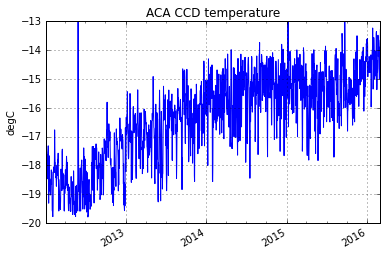

In [22]:
plot_cxctime(datd.times, datd.vals);
plt.ylim(-20, -13)
plt.grid()
plt.ylabel('degC')
plt.title('ACA CCD temperature');

In [10]:
date0 = DateTime('2012:180')
date1 = DateTime('2014:180')
i0, i1 = np.searchsorted(datd.times, [date0.secs, date1.secs])

In [11]:
secs = datd.times[i0:i1]
dyrs = (secs - secs[0]) / (86400 * 365.25)
vals = datd.vals[i0:i1]

In [12]:
r = np.polyfit(dyrs, vals, 1)
r

array([  1.45217614, -18.22650649])

In [13]:
degc_per_year = r[0]

In [14]:
t_model_now = np.polyval(r, (NOW - date0) / 365.0)
t_model_now

-13.125986461473207

In [15]:
dyrs = np.arange(6.0)

In [16]:
t_ccds = t_dat_now + degc_per_year * dyrs
t_ccds

array([-14.68463135, -13.23245521, -11.78027907, -10.32810293,
        -8.87592679,  -7.42375066])

In [17]:
set_fit_pars(ms_enabled=False)

In [18]:
dates = DateTime(NOW.frac_year + dyrs, format='frac_year')
mag50_disabled = [mag_for_p_acq(0.5, date=date, t_ccd=t_ccd) for date, t_ccd in zip(dates.date, t_ccds)]
mag50_disabled
    

[10.804731924050373,
 10.629055871677577,
 10.479916202895042,
 10.352722141226128,
 10.241733263344592,
 10.14792067402091]

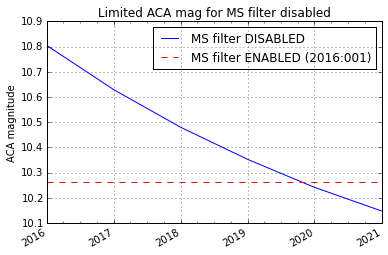

In [19]:
plot_cxctime(dates.secs, mag50_disabled, label='MS filter DISABLED')
plt.grid()
plt.ylabel('ACA magnitude')
plt.title('Limited ACA mag for MS filter disabled')
plot_cxctime(dates.secs, np.ones(len(dates.secs)) * mag50_enabled, '--r', label='MS filter ENABLED (2016:001)')
plt.legend(loc='upper right');

In [20]:
dyr_equiv = Ska.Numpy.interpolate(dyrs[::-1], mag50_disabled[::-1], np.array([mag50_enabled]))
date_equiv = NOW + dyr_equiv * 365.25
date_equiv.date[0]

'2019:292:17:40:08.336'